In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from chainconsumer import ChainConsumer
import numdifftools as nd 

In [9]:
dNdz_srcs = np.loadtxt('./dNdz_sources.dat')
dNdz_lenses = np.loadtxt('./dNdz_lenses.dat')
z_s = dNdz_srcs[:,0]; z_l = dNdz_lenses[:,0]
dNdz_s = dNdz_srcs[:,1:]; dNdz_l = dNdz_lenses[:,1:]

In [10]:
ell_path = 'ell-values'
ell = np.loadtxt(ell_path)
ell=ell[np.where(ell<2000)]
theta_deg = np.logspace(-1, np.log10(5.), len(ell)) # Theta is in degrees

In [3]:
#read covariances from clustering file
cov_path = 'cov_3x2pt_Y1_May2022 1.txt'
cov = np.loadtxt(cov_path)

In [12]:
# * each tomographic bin consists of 20 l-values ranging from 20-15000, with l-values >3000 being set to zero
Cell_bins_lensing=20
Cell_bins_lensing_cut=14

cov_lensing_auto_cut=np.zeros((Cell_bins_lensing_cut*27,Cell_bins_lensing_cut*27))

for i in range(Cell_bins_lensing_cut*27):
    for j in range(Cell_bins_lensing_cut*27):
        i_start=i*Cell_bins_lensing
        i_end=i*Cell_bins_lensing+Cell_bins_lensing_cut
        j_start=j*Cell_bins_lensing
        j_end=j*Cell_bins_lensing+Cell_bins_lensing_cut
        cov_lensing_auto_cut[i*Cell_bins_lensing_cut:(i+1)*Cell_bins_lensing_cut,j*Cell_bins_lensing_cut:(j+1)*Cell_bins_lensing_cut]=cov[i_start:i_end,j_start:j_end]

In [13]:
inv = np.linalg.inv(cov_lensing_auto_cut)
print(np.shape(inv))

(378, 378)


In [14]:
#dictionary of fiducial cosmology
p_dict =    {"ns" : 0.96,
             "s8" : 0.769,
             "h" : 0.7,
             "OmegaM" : 0.3,
             "OmegaB" : 0.05,
             "b1" : 1.562362,
             "b2" : 1.732963,
             "b3" : 1.913252,
             "b4" : 2.100644,
             "b5" : 2.293210
             }

In [15]:
ggl_bins=[[0,2],[0,3],[0,4],[1,3],[1,4],[2,4],[3,4]] #ggl bins as recommended is lsst desc srd
b= np.ones(len(z_l)) #linear galaxy bias

In [16]:
def C_ell_lenses(cosmology, z, dNdz_i, dNdz_j, bias, ell): 
    tracer_i = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z, dNdz_i), bias=(z, bias))
    tracer_j = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z, dNdz_j), bias=(z, bias))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [17]:
def C_ell_srcs(cosmology, z, dNdz_i, dNdz_j, ell): 
    tracer_i = ccl.WeakLensingTracer(cosmology, dndz=(z, dNdz_i))
    tracer_j = ccl.WeakLensingTracer(cosmology, dndz=(z, dNdz_j))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [18]:
def C_ell_cross(cosmology, z_i, dNdz_i, z_j, dNdz_j, bias, ell): 
    tracer_i = ccl.NumberCountsTracer(cosmology, has_rsd=False, dndz=(z_i, dNdz_i), bias=(z_i, bias))
    tracer_j = ccl.WeakLensingTracer(cosmology, dndz=(z_j, dNdz_j))
    C_ell = ccl.angular_cl(cosmology, tracer_i, tracer_j, ell)
    return C_ell

In [19]:
def P_ell(theta, h): 
    OmegaM=p_dict["OmegaM"]+h*theta[3]*p_dict["OmegaM"]
    OmegaB=p_dict["OmegaB"]+h*theta[4]*p_dict["OmegaB"]
    OmegaC= OmegaM - OmegaB  
    cosmo=ccl.Cosmology(Omega_c = OmegaC, 
                        Omega_b = OmegaB, 
                        n_s = p_dict["ns"] + h*theta[0]*p_dict["ns"], 
                        sigma8 = p_dict["s8"] + h*theta[1]*p_dict["s8"], 
                        h = p_dict["h"] + h*theta[2]*p_dict["h"])
    b_vals = [p_dict["b1"] + h*theta[5]*p_dict["b1"], 
              p_dict["b2"] + h*theta[6]*p_dict["b2"], 
              p_dict["b3"] + h*theta[7]*p_dict["b3"], 
              p_dict["b4"] + h*theta[8]*p_dict["b4"], 
              p_dict["b5"] + h*theta[9]*p_dict["b5"]]
    P_ell = []
    for i in range (0, 5): 
        j=i
        while j!=5: 
            P_ell.extend(C_ell_srcs(cosmo, z_s, dNdz_s[:,i], dNdz_s[:,j], ell))
            j=j+1
            
    for m in range (0, len(ggl_bins)): 
        i,j = ggl_bins[m]
        b_g = b_vals[i]*b
        P_ell.extend(C_ell_cross(cosmo, z_l, dNdz_l[:,i], z_s, dNdz_s[:,j],b_g, ell))
    
    for i in range (0,5): 
        b_g = b_vals[i]*b
        P_ell.extend(C_ell_lenses(cosmo, z_l, dNdz_l[:,i], dNdz_l[:,i], b_g, ell))
        
    P_ell = np.array(P_ell)
    return P_ell

In [20]:
def d(theta, h):
    P_ell_up = P_ell(theta, h)
    P_ell_down = P_ell(theta, -h)
    dP = (P_ell_up-P_ell_down)/(2*h)
    return dP

In [21]:
def R_e(theta, h):
    dP_h2 = d(theta,h/2)
    dP_h = d(theta,h)
    A = (4*dP_h2 - dP_h)/3
    return A 

The P_ell is differentiated by each parameter independently, by having an identity matrix theta that means every parameter is changed by 1 * h * parameter while all others are changed by 0 * h * parameter. In this code there is a set step size h over which we carry out the numerical differentiation. 

In [15]:
n_p = 10 #number of parameters interested in
theta = np.identity(n_p) 
h = 0.05

F=np.zeros(shape=(n_p, n_p))

for i in range (0, n_p): 
    for j in range (0, n_p):
        d_i = d(theta[i], h) #differentiate by parameter i of 10
        d_j = d(theta[j], h) #differentiate by parameter j of 10
        F[i,j] = np.matmul(np.matmul(d_i, inv), d_j)
        
C = np.linalg.inv(F)

## Fisher of priors

In [40]:
n_prior = 0.015
sigma8_prior = 0.01
h_prior = 3
omegam_prior = 0.05
omegab_prior = 0.2
b1_prior = 1
b2_prior = 1
b3_prior = 1
b4_prior = 1
b5_prior = 1

priors = np.square([n_prior, sigma8_prior, h_prior, omegam_prior, omegab_prior, b1_prior, b2_prior, b3_prior, b4_prior, b5_prior])
C_prior = np.diag(priors)
F_prior = np.linalg.inv(C_prior)

## Plot full covariance matrix 

In [41]:
F_full = F + F_prior
C = np.linalg.inv(F_full)

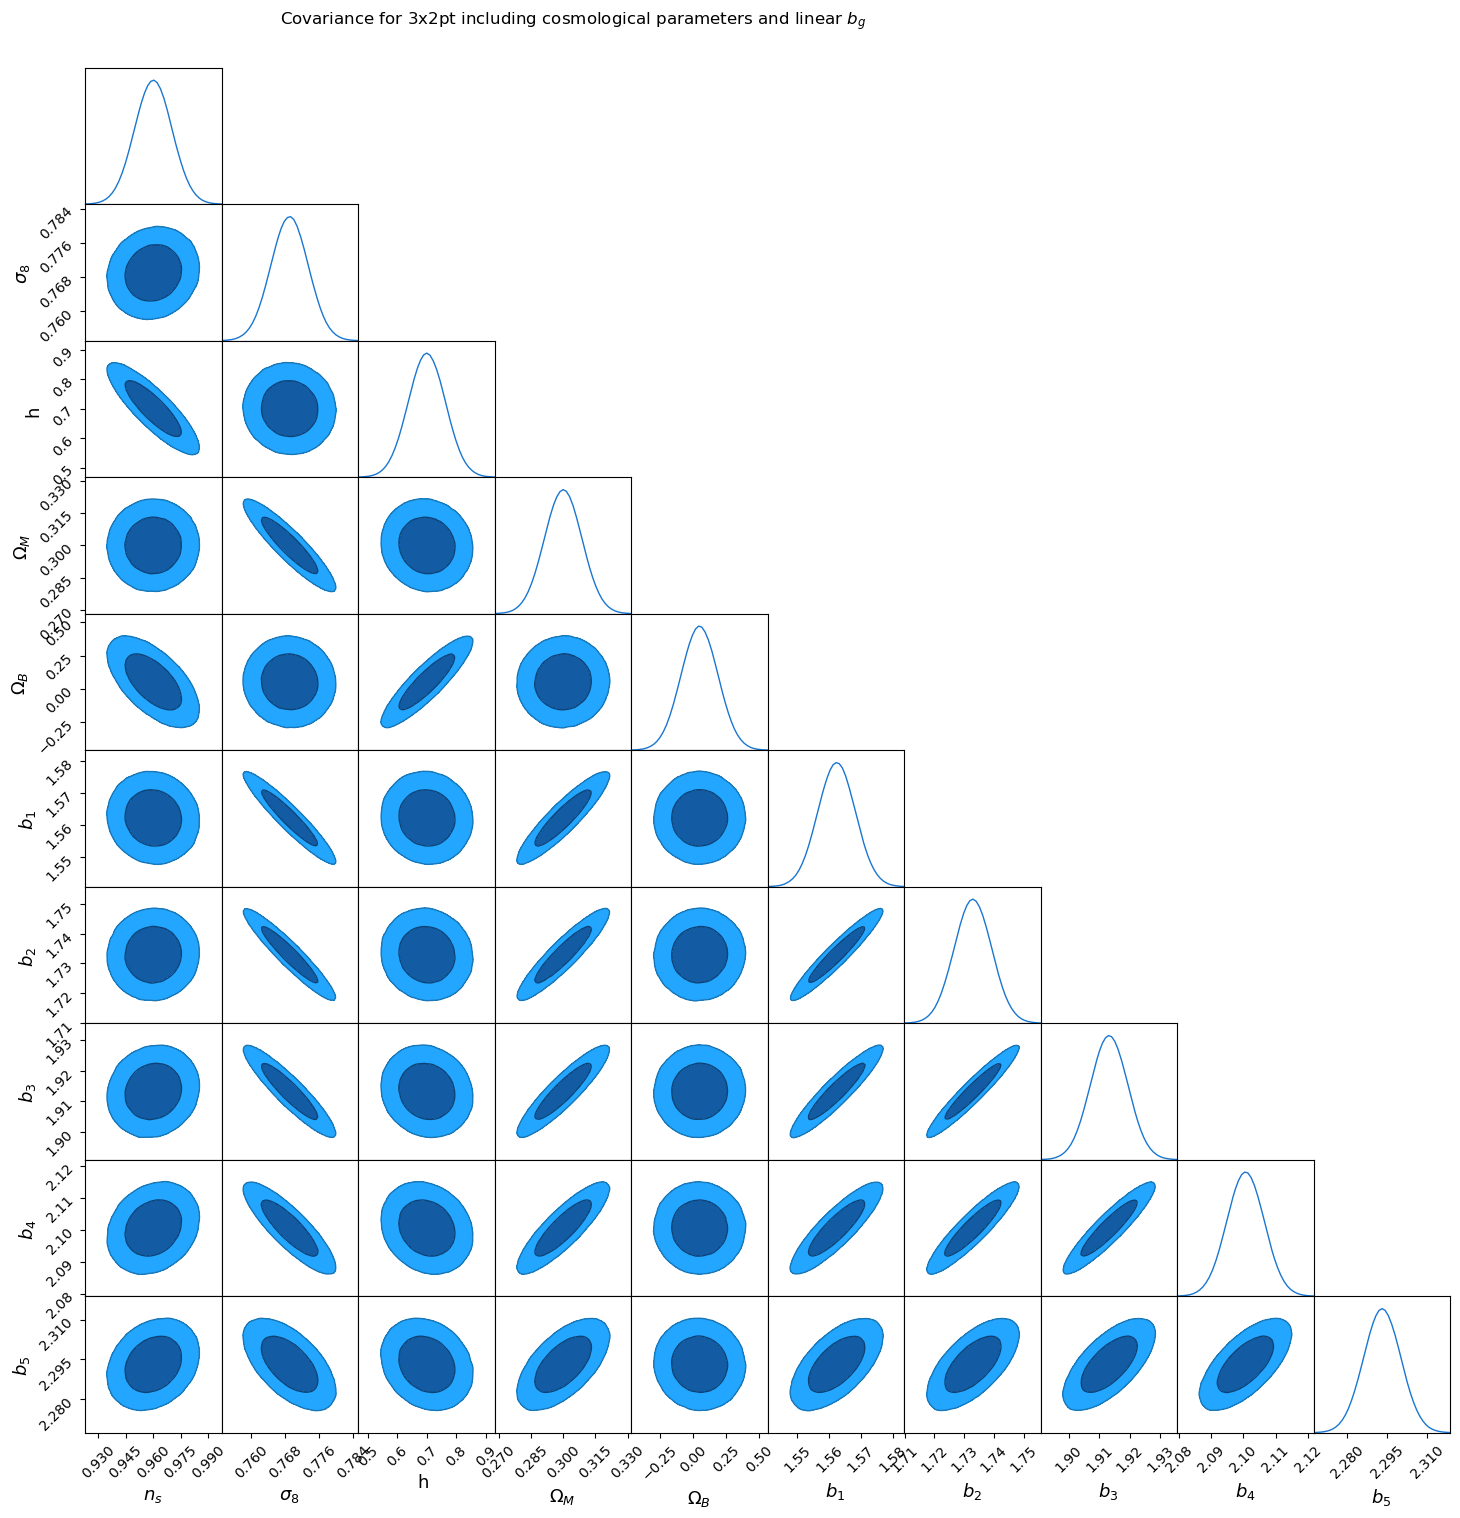

In [42]:
fiducial_params=[p_dict["ns"],p_dict["s8"], p_dict['h'], p_dict["OmegaM"], p_dict["OmegaB"], p_dict["b1"], p_dict["b2"], p_dict["b3"], p_dict["b4"], p_dict["b5"]]
param_strings=[r'$n_s$',r'$\sigma_8$', r'h', r'$\Omega_M$', r'$\Omega_B$', r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

chain = ChainConsumer()
chain.add_covariance(fiducial_params, C,  plot_contour=True, parameters=param_strings, color='blue', name=r'$b_g=1.562362$', linewidth=1, linestyle='-')
chain.configure(tick_font_size=10, label_font_size=13, flip=True, sigma2d=False, sigmas=[1,2], shade=True, bar_shade=False, smooth=1, legend_artists=True)

fig = chain.plotter.plot()
fig.set_size_inches(4.5 + fig.get_size_inches())
plt.subplots_adjust(bottom=0.25, left=0.25, right=0.95, top=0.95)
plt.suptitle("Covariance for 3x2pt including cosmological parameters and linear $b_g$") 
plt.savefig("descbiases")
plt.show()